### Dependencies

In [1]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.qhull import Delaunay

/var/folders/5s/7z5kptnj64x87q0xrkz1nwfc0000gn/T/ipykernel_15364/3867941674.py:5: DeprecationWarning: Please import `Delaunay` from the `scipy.spatial` namespace; the `scipy.spatial.qhull` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.qhull import Delaunay


# Project 3 - Face Morphing

## Part 1. Defining Correspondences

In [2]:
face_a = cv2.imread('../data/filip.jpg')
face_b = cv2.imread('../data/emelie.jpg')

# the points are defined in a json file called filip_emelie.json
with open('../data/filip_emelie.json', 'r') as f:
    points = json.load(f)

im1_points = np.array(points["im1Points"])
im2_points = np.array(points["im2Points"])

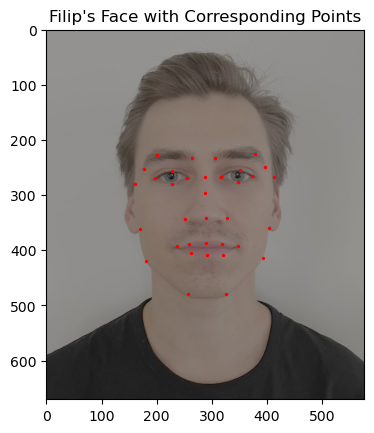

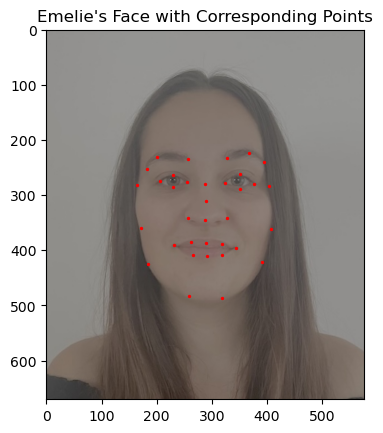

In [3]:
import cv2
import matplotlib.pyplot as plt

# Helper function to plot points on an image
def plot_points_on_face(image, points, title="Image with Points"):
    # Convert image to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot image
    plt.imshow(image_rgb)
    plt.scatter(points[:, 0], points[:, 1], color='red', marker='o', s=2)
    
    # Set axis limits to match image size
    plt.xlim(0, image.shape[1])  # Width of the image
    plt.ylim(image.shape[0], 0)  # Height of the image, inverted Y-axis
    
    # Set title and show the plot
    plt.title(title)
    plt.show()

# Plot Filip's points on Filip's face
plot_points_on_face(face_a, im1_points, title="Filip's Face with Corresponding Points")

# Plot Emelie's points on Emelie's face
plot_points_on_face(face_b, im2_points, title="Emelie's Face with Corresponding Points")

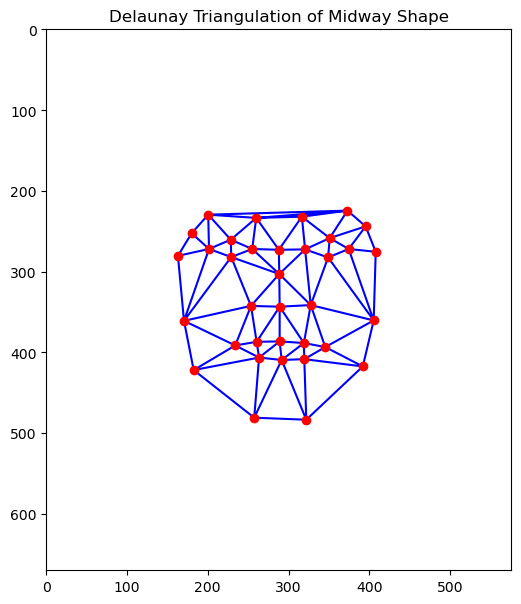

In [4]:
# Compute the midway shape points (average of corresponding points)
midway_points = (im1_points + im2_points) / 2

# Perform Delaunay triangulation on the midway points
tri = Delaunay(midway_points)

# Visualize the triangulation on the midway shape
plt.figure(figsize=(6, 8))  # Adjust the figure size to match the image proportions

# Plot the Delaunay triangulation
plt.triplot(midway_points[:, 0], midway_points[:, 1], tri.simplices, color='blue')
plt.scatter(midway_points[:, 0], midway_points[:, 1], color='red')

# Set the aspect ratio to match the image dimensions
plt.gca().set_aspect('equal', adjustable='box')

# Set axis limits to match image size (width x height = 576 x 670)
plt.xlim(0, 576)
plt.ylim(670, 0)  # Invert Y-axis to match image coordinates

# Display the plot
plt.title("Delaunay Triangulation of Midway Shape")
plt.show()

## Part 2. Computing the "Mid-way Face"

In [5]:
import numpy as np

def compute_affine(tri1_pts, tri2_pts):
    # Create matrices for triangle points
    tri1 = np.vstack((tri1_pts.T, np.ones((1, 3))))
    tri2 = np.vstack((tri2_pts.T, np.ones((1, 3))))
    
    # Compute the affine transformation matrix A
    A = np.dot(tri2, np.linalg.inv(tri1))
    
    return A


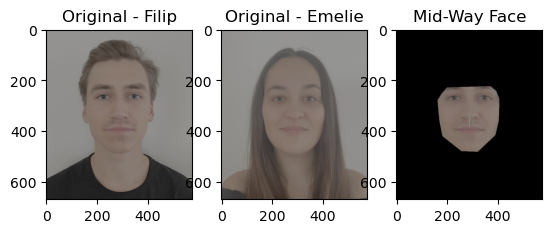

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import polygon

# Helper function to warp a triangle from one image to another
def warp_triangle(img, src_tri, dst_tri, dst_shape):
    # Compute affine transformation matrix
    A = compute_affine(src_tri, dst_tri)
    
    # Create mask for destination triangle
    rr, cc = polygon(dst_tri[:, 1], dst_tri[:, 0], shape=dst_shape)
    
    # Apply inverse warp to find the corresponding pixel in the source image
    coords = np.vstack((cc, rr, np.ones(len(rr))))
    warped_coords = np.dot(np.linalg.inv(A), coords)
    
    # Interpolation to find pixel values in the source image
    x_warped = np.clip(warped_coords[0].astype(int), 0, img.shape[1]-1)
    y_warped = np.clip(warped_coords[1].astype(int), 0, img.shape[0]-1)
    
    # Warp pixels from the source image
    warped_img = np.zeros_like(img)
    warped_img[rr, cc] = img[y_warped, x_warped]
    
    return warped_img

# Helper function to perform the morphing process
def compute_midway_face(img_a, img_b, points_a, points_b, triangles):
    # Compute the average points (average shape)
    avg_points = (points_a + points_b) / 2
    
    # Empty images to store the warped results
    warped_a = np.zeros_like(img_a)
    warped_b = np.zeros_like(img_b)
    
    # Loop over each triangle and warp both images to the average shape
    for tri_indices in triangles.simplices:
        # Get the points of the triangles in both images and the average
        tri_a = points_a[tri_indices]
        tri_b = points_b[tri_indices]
        tri_avg = avg_points[tri_indices]
        
        # Warp the triangles in both images to the average shape
        warped_a += warp_triangle(img_a, tri_a, tri_avg, img_a.shape)
        warped_b += warp_triangle(img_b, tri_b, tri_avg, img_b.shape)
    
    # Average the colors of the warped images
    midway_face = (warped_a / 2 + warped_b / 2).astype(np.uint8)
    
    return midway_face

# Load the images (both images should be the same size)
face_a = cv2.imread('../data/filip.jpg')
face_b = cv2.imread('../data/emelie.jpg')

# Load the keypoints (assumed to be loaded from a json or manually clicked)
points_a = np.array(points['im1Points'])
points_b = np.array(points['im2Points'])

# Compute the Delaunay triangulation (using the average shape)
average_points = (points_a + points_b) / 2
tri = Delaunay(average_points)

# Compute the mid-way face
midway_face = compute_midway_face(face_a, face_b, points_a, points_b, tri)

# Display the original and mid-way face
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(face_a, cv2.COLOR_BGR2RGB))
plt.title("Original - Filip")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(face_b, cv2.COLOR_BGR2RGB))
plt.title("Original - Emelie")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(midway_face, cv2.COLOR_BGR2RGB))
plt.title("Mid-Way Face")

plt.show()
